In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [4]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [5]:
!tar -xf lfw.tgz

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\954912fd-4c3d-11ef-9987-346f24c84abc.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # for anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # for positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:

print(dir_test.next())

b'data\\anchor\\e8cef497-4b5b-11ef-a429-346f24c84abc.jpg'


In [21]:

def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [22]:
img = preprocess('data\\anchor\\2466c6b7-4b5b-11ef-833c-346f24c84abc.jpg')

In [23]:

img.numpy().max() 

0.93235296

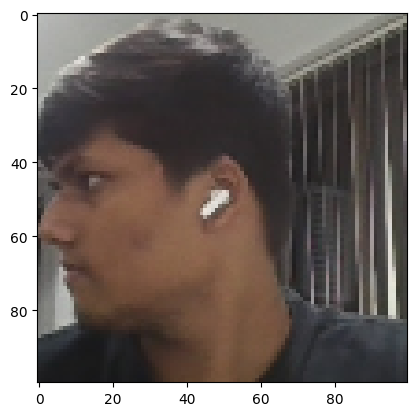

In [24]:

plt.imshow(img)

In [ ]:
dataset.map(preprocess)

# Getting image directories

In [26]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [29]:
data

<_ConcatenateDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [30]:
samples = data.as_numpy_iterator()


In [31]:
example = samples.next()

In [ ]:
#partition

In [34]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [33]:
res = preprocess_twin(*example)

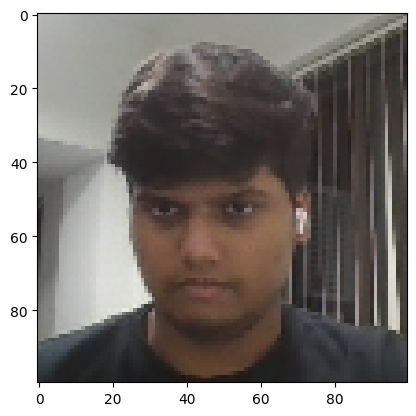

In [35]:
plt.imshow(res[0])

In [36]:
#dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [37]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [38]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

## MODEL

In [39]:
#conv relu maxpool -> conv relu maxpool -> conv relu maxpool-> conv relu fully_connected + sigmoid + L1 Siamese dist -> fully_connected + sigmoid

In [40]:
inp = Input(shape=(100,100,3), name='input_image')

In [41]:
c1 = Conv2D(64,(10,10), activation='relu')(inp)

In [42]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [43]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [44]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [45]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [46]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [47]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [48]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [49]:
embedding = make_embedding()

In [50]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 46, 46, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 17, 17, 128)       26

# Distance Layer

In [51]:
# Siamese L1 Distance class
class L1Dist(Layer):
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    #norm of diff of x1 and x2
    #input_embedding is the x1 vector
    #validation_embedding is the x2 vector
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [52]:
l1 = L1Dist()

In [53]:
l1

# Siamese model

In [54]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [55]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [56]:
siamese_layer = L1Dist()

In [57]:
distances = siamese_layer(inp_embedding, val_embedding)

In [58]:
classifier = Dense(1, activation='sigmoid')(distances)

In [59]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [60]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [61]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [62]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    
    #In this we are passing our input and validation image to embedding function
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [63]:
siamese_model = make_siamese_model()

In [64]:
# here there are the dimesnsions of the output layers 
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

# Training

In [65]:
# flow of the training on one batch is
#1 make prediciton
#2 calculate loss
#3 derive gradients 
#4 calculate new weights and apply

In [66]:
binary_cross_loss = tf.losses.BinaryCrossentropy() # loss function

In [67]:
opt = tf.keras.optimizers.Adam(1e-4)  # optimizers

In [68]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [69]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [70]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# Training the model


In [71]:
train(train_data, EPOCHS=50)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 95s 3s/step

 Epoch 2/50
27/27 [==============================] - 97s 4s/step

 Epoch 3/50
27/27 [==============================] - 102s 4s/step

 Epoch 4/50
27/27 [==============================] - 100s 4s/step

 Epoch 5/50
27/27 [==============================] - 107s 4s/step

 Epoch 6/50
27/27 [==============================] - 112s 4s/step

 Epoch 7/50
27/27 [==============================] - 108s 4s/step

 Epoch 8/50
27/27 [==============================] - 108s 4s/step

 Epoch 9/50
27/27 [==============================] - 107s 4s/step

 Epoch 10/50
27/27 [==============================] - 108s 4s/step

 Epoch 11/50
27/27 [==============================] - 108s 4s/step

 Epoch 12/50
27/27 [==============================] - 109s 4s/step

 Epoch 13/50
27/27 [====================

# Evaluate model

In [163]:
# metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [188]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [189]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 1s 1s/step


array([[4.1688121e-08],
       [7.9926499e-10],
       [1.0000000e+00],
       [1.4734777e-10],
       [9.9983841e-01],
       [1.0000000e+00],
       [9.9861753e-01],
       [1.4838282e-10],
       [9.9492282e-11],
       [9.9847710e-01],
       [1.8026951e-08],
       [9.9496134e-10],
       [1.0000000e+00],
       [9.9994802e-01],
       [1.0000000e+00],
       [1.2031140e-06]], dtype=float32)

In [190]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]

In [191]:
y_true

array([0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 0.],
      dtype=float32)

# Calculating metrics

In [192]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

# Results

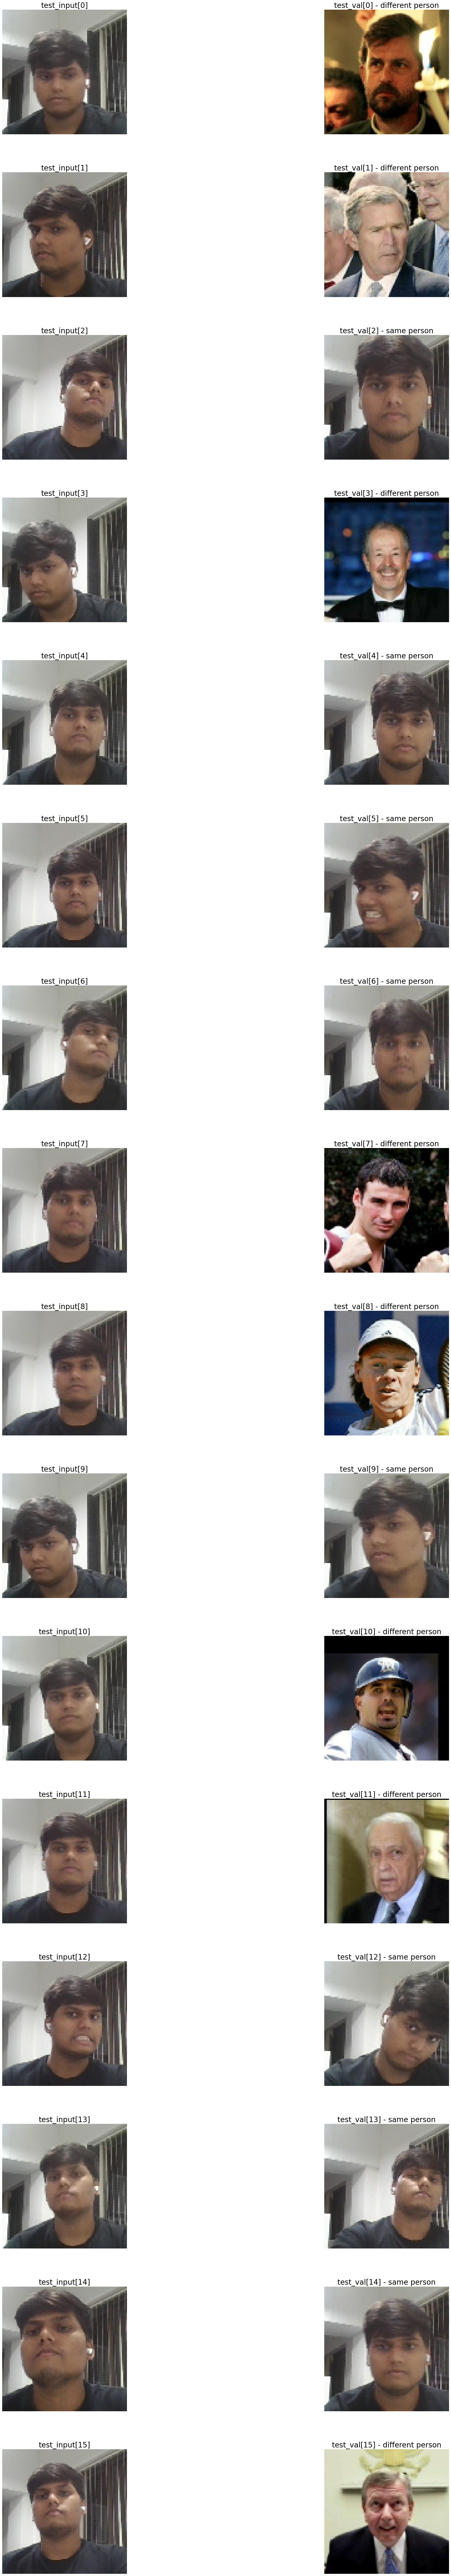

In [204]:
import matplotlib.pyplot as plt

plt.figure(figsize=(40, 120))

for i in range(len(y_true)):
    plt.subplot(16, 2, 2 * i + 1)
    plt.imshow(test_input[i])
    plt.axis('off')
    plt.title(f'test_input[{i}]', fontsize=24)

    plt.subplot(16, 2, 2 * i + 2)
    plt.imshow(test_val[i])
    plt.axis('off')
    result = 'same person' if y_true[i] == 1.0 else 'different person'
    plt.title(f'test_val[{i}] - {result}', fontsize=24)

plt.tight_layout(pad=10.0)
plt.show()


# Saving model

In [196]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [198]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})


In [201]:
model.predict([test_input, test_val])

1/1 [==============================] - 1s 1s/step


array([[4.1688121e-08],
       [7.9926499e-10],
       [1.0000000e+00],
       [1.4734777e-10],
       [9.9983841e-01],
       [1.0000000e+00],
       [9.9861753e-01],
       [1.4838282e-10],
       [9.9492282e-11],
       [9.9847710e-01],
       [1.8026951e-08],
       [9.9496134e-10],
       [1.0000000e+00],
       [9.9994802e-01],
       [1.0000000e+00],
       [1.2031140e-06]], dtype=float32)

In [202]:
# model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     